importing Jupyter notebook from C:\Users\posor\OneDrive\Asztali gép\szakdolgozat_repo\szakdolgozat\szakdolgozat\notebooks\test.ipynb
importing Jupyter notebook from C:\Users\posor\OneDrive\Asztali gép\szakdolgozat_repo\szakdolgozat\szakdolgozat\notebooks\create_from_txt.ipynb
importing Jupyter notebook from C:\Users\posor\OneDrive\Asztali gép\szakdolgozat_repo\szakdolgozat\szakdolgozat\notebooks\link_prediction.ipynb


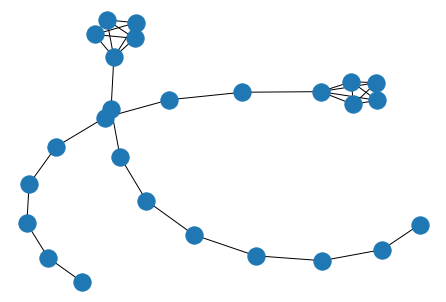

In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell
import networkx as nx
import matplotlib.pyplot as plt

cwd = os.getcwd()
sys.path.insert(0, cwd+'\\notebooks')

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
        
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]
    
sys.meta_path.append(NotebookFinder())

import notebooks.test as test
import notebooks.create_from_txt as txtreader
import notebooks.link_prediction as lp

#G = nx.Graph()


In [2]:
G = txtreader.from_txt("facebook_combined.txt")

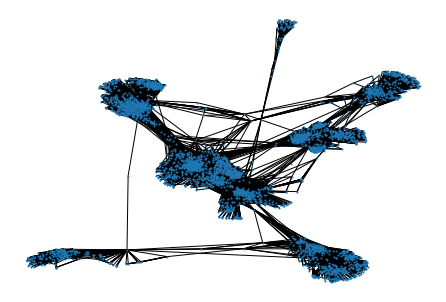

In [3]:
nx.draw(G,node_size=1)
plt.draw()

In [2]:
G = txtreader.from_csv("BTCAlphaNet.csv")

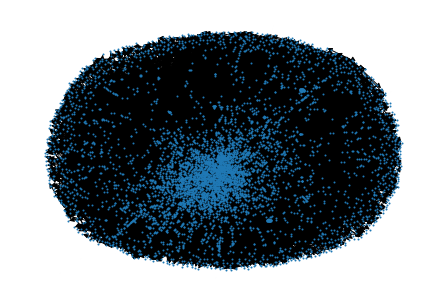

In [9]:
nx.draw(G,node_size=1)
plt.draw()

In [3]:
G2 = G.copy() 
lp.lp(G2)
print(G.size())
print(G2.size())

number of edges: 2424
-----------------
Iteration number 0
Updating goodness
Updating fairness
-----------------
Iteration number 1
Updating goodness
Updating fairness
-----------------
Iteration number 2
Updating goodness
Updating fairness
-----------------
Iteration number 3
Updating goodness
Updating fairness
-----------------
Iteration number 4
Updating goodness
Updating fairness
-----------------
Iteration number 5
Updating goodness
Updating fairness
-----------------
Iteration number 6
Updating goodness
Updating fairness
-----------------
Iteration number 7
Updating goodness
Updating fairness
-----------------
Iteration number 8
Updating goodness
Updating fairness
-----------------
Iteration number 9
Updating goodness
Updating fairness
-----------------
Iteration number 10
Updating goodness
Updating fairness
-----------------
Iteration number 11
Updating goodness
Updating fairness
-----------------
Iteration number 12
Updating goodness
Updating fairness
(149.0, 660.0, 0.1, 0.1101

(125.0, 817.0, 0.1, 0.13288088233022913)
(92.0, 27.0, 0.1, 0.18721494319937843)
(185.0, 349.0, 0.3, 0.25708569718641916)
(356.0, 8.0, 0.1, 0.21266520849916623)
(319.0, 799.0, 0.3, 0.1260504024325625)
(801.0, 350.0, 0.1, 0.13676837619533558)
(424.0, 638.0, 0.1, 0.18761183276016744)
(43.0, 1331.0, 0.1, 0.0866694575953562)
(46.0, 1274.0, 0.1, 0.11494214163450434)
(926.0, 1244.0, 0.1, 0.2254967582818123)
(145.0, 1761.0, 0.1, 0.13007874465180336)
(862.0, 671.0, 0.2, 0.1596050589074577)
(186.0, 364.0, 0.5, 0.49663960493982545)
(7595.0, 288.0, 0.1, 0.06924717842164883)
(201.0, 535.0, 0.1, 0.11581778172143783)
(42.0, 79.0, 0.2, 0.11052358201475457)
(2459.0, 2.0, 0.1, 0.29207038560474885)
(7595.0, 3.0, 0.3, 0.20040597430096457)
(768.0, 16.0, 0.1, 0.194007348605412)
(15.0, 1905.0, 0.1, 0.08373702318840265)
(4.0, 2201.0, 0.2, 0.17836070166438786)
(360.0, 1038.0, 0.1, 0.10632418824065647)
(259.0, 262.0, 0.1, 0.19169267744224752)
(47.0, 83.0, 0.2, 0.14296290754560992)
(15.0, 2633.0, 0.1, 0.08369465

(111.0, 49.0, 0.1, 0.1724078226448301)
(13.0, 2284.0, 0.2, 0.1743961191070015)
(470.0, 2546.0, 0.1, 0.09318850398225938)
(5.0, 801.0, 0.1, 0.03983386080642789)
(87.0, 259.0, 0.1, 0.12086010192162357)
(2634.0, 176.0, -0.1, 0.1310614458914638)
(436.0, 2.0, 0.1, 0.28877946956431466)
(67.0, 10.0, 0.5, 0.1572639279018638)
(2.0, 1922.0, 0.1, 0.08584452918488754)
(369.0, 2034.0, 0.2, 0.184819220824212)
(3414.0, 1.0, 0.1, 0.1685917157964894)
(211.0, 21.0, 0.2, 0.20130414322454257)
(173.0, 26.0, 0.1, 0.13271222925201898)
(7412.0, 87.0, 0.1, 0.13293193318778176)
(275.0, 1683.0, 0.2, 0.1340949158790861)
(1046.0, 29.0, 0.2, 0.17039983658330374)
(333.0, 3.0, 0.6, 0.20780874176927508)
(686.0, 69.0, 0.1, 0.12212766760904573)
(1378.0, 36.0, 0.1, 0.17966646321470875)
(1792.0, 25.0, 0.1, 0.16834242570026475)
(24.0, 63.0, 0.6, 0.21005674889141332)
(33.0, 305.0, 0.2, 0.15513209884171184)
(473.0, 182.0, 0.2, 0.1550470419008765)
(1246.0, 7564.0, 0.5, -0.02476303844809486)
(2102.0, 231.0, 0.1, 0.200403410538

(241.0, 751.0, 0.1, 0.143497457105905)
(136.0, 3.0, 0.2, 0.21340668186813505)
(264.0, 593.0, 0.1, 0.11131649492440465)
(33.0, 255.0, 0.1, 0.08843876280012572)
(81.0, 64.0, 0.1, 0.1930183265899582)
(3291.0, 982.0, 0.1, 0.1429016248902189)
(651.0, 984.0, 0.1, 0.11184142953830327)
(15.0, 7330.0, -0.1, -0.08369465422649564)
(1612.0, 273.0, 0.2, 0.29760100280160817)
(65.0, 53.0, 0.1, 0.19386014634089777)
(1.0, 89.0, 0.3, 0.14406505766482167)
(46.0, 1801.0, 0.3, 0.27796633610109617)
(4.0, 918.0, 0.1, 0.1212906194538871)
(1686.0, 2621.0, 0.1, 0.09683260904600918)
(502.0, 7552.0, 0.7, -0.035685844133772564)
(136.0, 97.0, 0.1, 0.15892296400166903)
(650.0, 105.0, 0.1, 0.1608416505099353)
(1187.0, 3199.0, 0.1, 0.09493372477236464)
(798.0, 161.0, 0.1, 0.12236787732149237)
(130.0, 7564.0, 0.2, -0.027923193052456306)
(117.0, 24.0, 0.3, 0.2051817213880703)
(1586.0, 12.0, 0.3, 0.18730551786154934)
(46.0, 3308.0, 0.1, 0.09265544536703205)
(1134.0, 7580.0, -0.5, -0.16360657936762082)
(15.0, 7562.0, -1.0

(5.0, 7510.0, -1.0, -0.35900491680352187)
(2.0, 7.0, 0.3, 0.1739431238178881)
(396.0, 3.0, 0.3, 0.21215770172539788)
(111.0, 7601.0, -1.0, -0.6838591473584414)
(982.0, 3291.0, 0.1, 0.09225479767681284)
(145.0, 42.0, 0.1, 0.1410623484678373)
(26.0, 47.0, 0.6, 0.2325539436585935)
(28.0, 7394.0, 0.1, 0.014473354189883962)
(5415.0, 41.0, 0.2, 0.17889348890933252)
(4.0, 1634.0, 0.2, 0.133098247012806)
(133.0, 391.0, 0.1, 0.13338961389532575)
(84.0, 4.0, 0.3, 0.2591716229145704)
(254.0, 195.0, 1.0, 0.3146536088057981)
(4.0, 1615.0, 0.2, 0.13510296529370297)
(94.0, 96.0, 0.1, 0.15156775699488045)
(7.0, 22.0, 0.1, 0.16905050112892359)
(247.0, 336.0, 0.2, 0.15999978636525866)
(26.0, 505.0, 0.1, 0.11729917695241113)
(287.0, 12.0, 0.1, 0.18449140009355403)
(140.0, 2318.0, 0.1, 0.0904358264130523)
(519.0, 2899.0, 0.1, 0.09264378650757404)
(453.0, 950.0, 0.8, 0.7723539462062734)
(1.0, 951.0, 0.1, 0.09228817420490648)
(97.0, 211.0, 0.1, 0.11457024244211886)
(38.0, 152.0, 0.5, 0.16648090033634835)
(3

IndexError: Cannot choose from an empty sequence

In [ ]:
G = nx.DiGraph()

f = open("BTCAlphaNet.csv","r")
for l in f:
    ls = l.strip().split(",")
    G.add_edge(ls[0], ls[1], weight = float(ls[2])) ## the weight should already be in the range of -1 to 1
f.close()

G2 = G.copy() 
lp.lp(G2)
print(G.size())
print(G2.size())